In [1]:
from vampyr import vampyr3d as vp
import numpy as np
import matplotlib.pyplot as plt

# Scaling and wavelet functions

First we need to select our scaling functions $\{\phi_i\}_{i=0}^k$. In general we choose or scaling functions $\phi_i$to be either [Legendre Polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials) or [Interpolating Polynomials](https://en.wikipedia.org/wiki/Polynomial_interpolation). I'll use Legendre Polynomials in these examples.

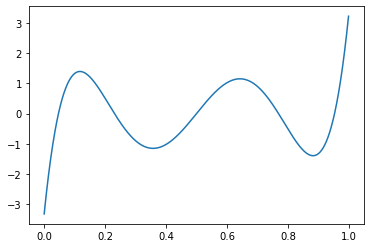

In [25]:
from vampyr import LegendreBasis

basis_set = LegendreBasis(5)
scaling = basis_set.scaling


x = np.arange(0.0, 1.0, 0.001)
y = [scaling(i=5)([_]) for _ in x] # Luca, er det rett å si linear, quadratic, cubic
plt.plot(x, y)

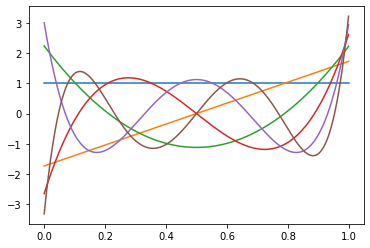

In [26]:
x = np.arange(0.0, 1.0, 0.001)
for i in range(6):
    y = [scaling(i=i)([x]) for x in x]
    plt.plot(x, y)

Let's have a MultiResolution of of these scaling functions, we do this by dilation and translation

\begin{align}
    \phi_{i, l}^n(x) &= 2^{n/2} \phi_i(2^nx - l)
\end{align}

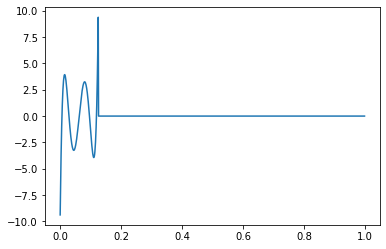

In [32]:
x = np.arange(0.0, 1.0, 0.001)
y = [scaling(i=i, l=0, n=3)([x]) for x in x]
plt.plot(x, y)

Now let's introduce our wavelet functions $\psi_{i, l}^n$. They are connected to the scaling functions through the two-scale difference relation:

\begin{align}
\phi_i(x) = \sqrt{2} \sum_j h^{(0)}_{ij} \phi_j(2x) + h^{(1)}_{ij} \phi_j(2x-1) \\
\psi_i(x) = \sqrt{2} \sum_j g^{(0)}_{ij} \phi_j(2x) + g^{(1)}_{ij} \phi_j(2x-1) \\
\end{align}


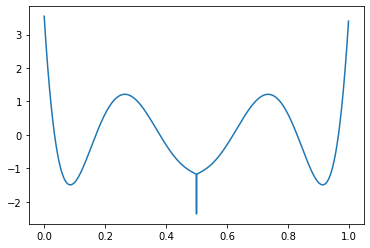

In [35]:
wavelet = basis_set.wavelet


x = np.arange(0.0, 1.0, 0.001)
y = [wavelet(i=0)([_]) for _ in x] # Luca, er det rett å si linear, quadratic, cubic
plt.plot(x, y)

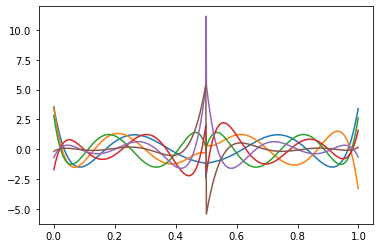

In [42]:
x = np.arange(0.0, 1.0, 0.001)
for i in range(6):
    y = [wavelet(i=i, n=0)([x]) for x in x]
    plt.plot(x, y)

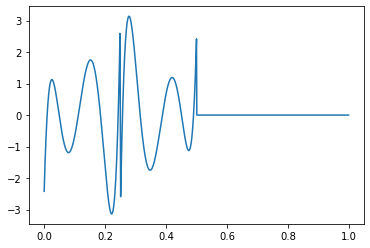

In [48]:
x = np.arange(0.0, 1.0, 0.001)
y = [wavelet(i=3, l=0, n=1)([x]) for x in x]
plt.plot(x, y)

# Scaling and Wavelet Projectors


Let's introduce the Scaling Projection operator $P^n_k$. This operator projects the function $f$ onto the
scaling basis $\{\phi_{j,l}^n\}$. I.e.,

\begin{align}
f^n(x) = P^n_k [f(x)] = \sum_{l=0}^{2^n-1} \sum_{j=0}^k s_{j, l}^{n,f} \phi_{j,l}^n(x) 
\end{align}

In [ ]:
Del 2. 

Introduser Scaling og Wavelet projectors

først en glatt gauss så en spiss

p0, p1, p2

1. p0, ...
2. Qn
3. P^n+1 = sum Q_n + P^0 (print node size) vis at de er like
4. P_eps (print node size) vis at de er like



In [ ]:
world = vp.BoundingBox(nboxes=[2, 2, 2], corner=[-1, -1, -1], scale=-3)

mra = vp.MultiResolutionAnalysis(world, 5)

f = vp.FunctionTree(mra)

f.loadTree("phi_p_scf_idx_0_re")

from grid_plotter import grid_plotter

grid_plotter(f)